# Индивидуальное задание “Индустриальный анализ данных”
Пан Анатолий Эдуардович

группа 932209

**Вариант 6**. Построить модель обнаружения на основе алгоритма KNN. В качестве предварительной обработки сигналов использовать преобразование Гильберта Хуанга (библиотека pyhtt). Исследовать как минимум 3 уровня разложения.  


## Необходимые библиотеки

In [1]:
!pip install rarfile pyhht pyod -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
import os
import rarfile
import matplotlib.pyplot as plt
from pyhht.emd import EMD
from pyhht.visualization import plot_imfs
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Загрузка данных

Для начала работы подключим Google Drive, чтобы иметь доступ к данным

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Сменим директорию
os.chdir("/content/drive/MyDrive/masters/Industrial Data Analysis")

Т.к. набор данных в формате .rar, то выполним его распаковку

In [5]:
rar_path = "/content/drive/MyDrive/masters/Industrial Data Analysis/dataset.rar"
extract_folder = "/content/drive/MyDrive/masters/Industrial Data Analysis/dataset"

with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_folder)

Чтение данных. Для каждого файла train соотвествует test из 10 сэмплов. В файле mask лежат метки значений 0 - нормальное значение, 1 - аномалия

In [219]:
for i in range(1, 2):
    print(f"signal = {i}")
    X_train = np.load(f"dataset/train/train{i}.npy")
    X_tests = np.load(f"dataset/test/test{i}.npy")
    X_masks = np.load(f"dataset/mask/mask{i}.npy")

signal = 1


Размерность данных после их чтения

In [220]:
print(X_train.shape, X_tests.shape, X_masks.shape)

(64800,) (10, 10080) (10, 10080)


Выполним визуализацию входных данных: tests & masks, на одной из частей сигнала

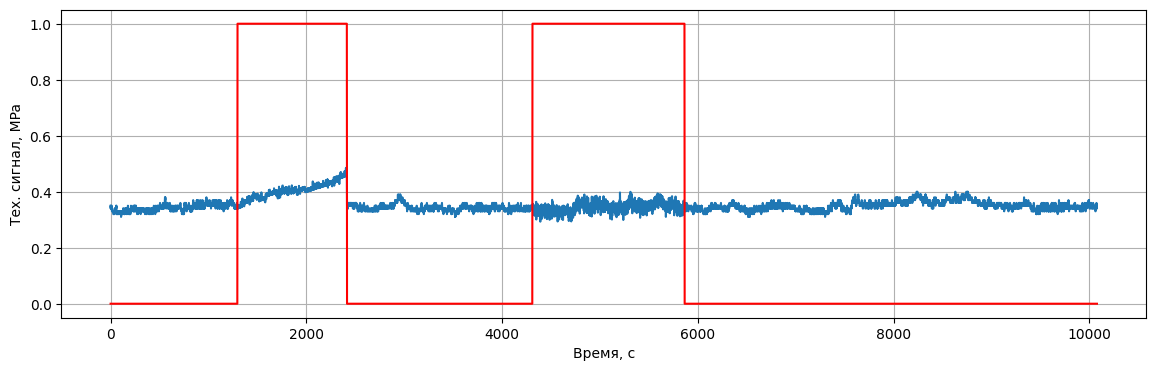

In [221]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests[0])
ax1.plot(X_masks[0], color="red")
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

## Предобработка данных

Склеим все части сигнала и маски в один массив

In [222]:
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

In [223]:
print("Размеры данных для обучения:", X_train.shape)
print("Размеры тестовых данных:", X_tests.shape)
print("Размеры маски аномалий:", X_masks.shape)

Размеры данных для обучения: (64800,)
Размеры тестовых данных: (100800, 1)
Размеры маски аномалий: (100800, 1)


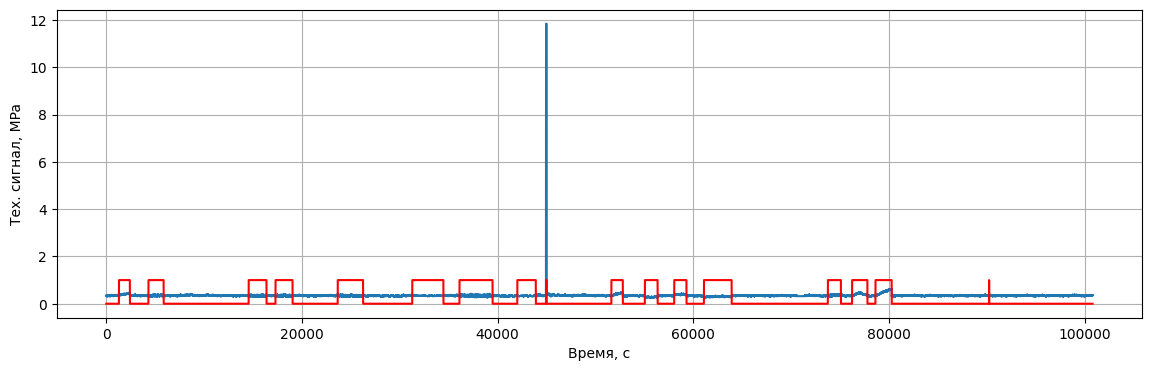

In [224]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests)
ax1.plot(X_masks, color="red")
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

Выполним преобразование Гильберта-Хуанга, используя библиотеку pyhht

Преобразование Гильберта-Хуанга (HHT) — это преобразование, которое представляет собой разложение сигнала на эмпирические моды, с последующим применением к полученным компонентам разложения преобразования Гильберта

In [225]:
def hht_transform(data, num_levels=3):
    emd = EMD(data)
    imfs = emd.decompose()
    num_levels = min(num_levels, len(imfs))
    hht_result = []
    for i in range(num_levels):
        hht_result.append(np.sum(imfs[:i + 1], axis=0))
    return np.vstack(hht_result).T


In [226]:
num_levels = 4
train_transformed = hht_transform(X_train, num_levels)
test_transformed = hht_transform(X_tests, num_levels)

Mode 2, Iteration 600
1 minima > 0; 11840 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 11890 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 11943 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 7298 maxima < 0.
Mode 4, Iteration 1400
0 minima > 0; 4304 maxima < 0.
Mode 9, Iteration 1600
2 minima > 0; 172 maxima < 0.
Mode 13, Iteration 1800
0 minima > 0; 10 maxima < 0.
Mode 1, Iteration 600
0 minima > 0; 32965 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 33036 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 33114 maxima < 0.
Mode 2, Iteration 1200
19 minima > 0; 19935 maxima < 0.
Mode 2, Iteration 1400
7 minima > 0; 20257 maxima < 0.
Mode 2, Iteration 1600
1 minima > 0; 20374 maxima < 0.
Mode 2, Iteration 1800
3 minima > 0; 20478 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


In [227]:
train_transformed.shape, test_transformed.shape

((64800, 4), (100800, 3))

Визуализируем разложения

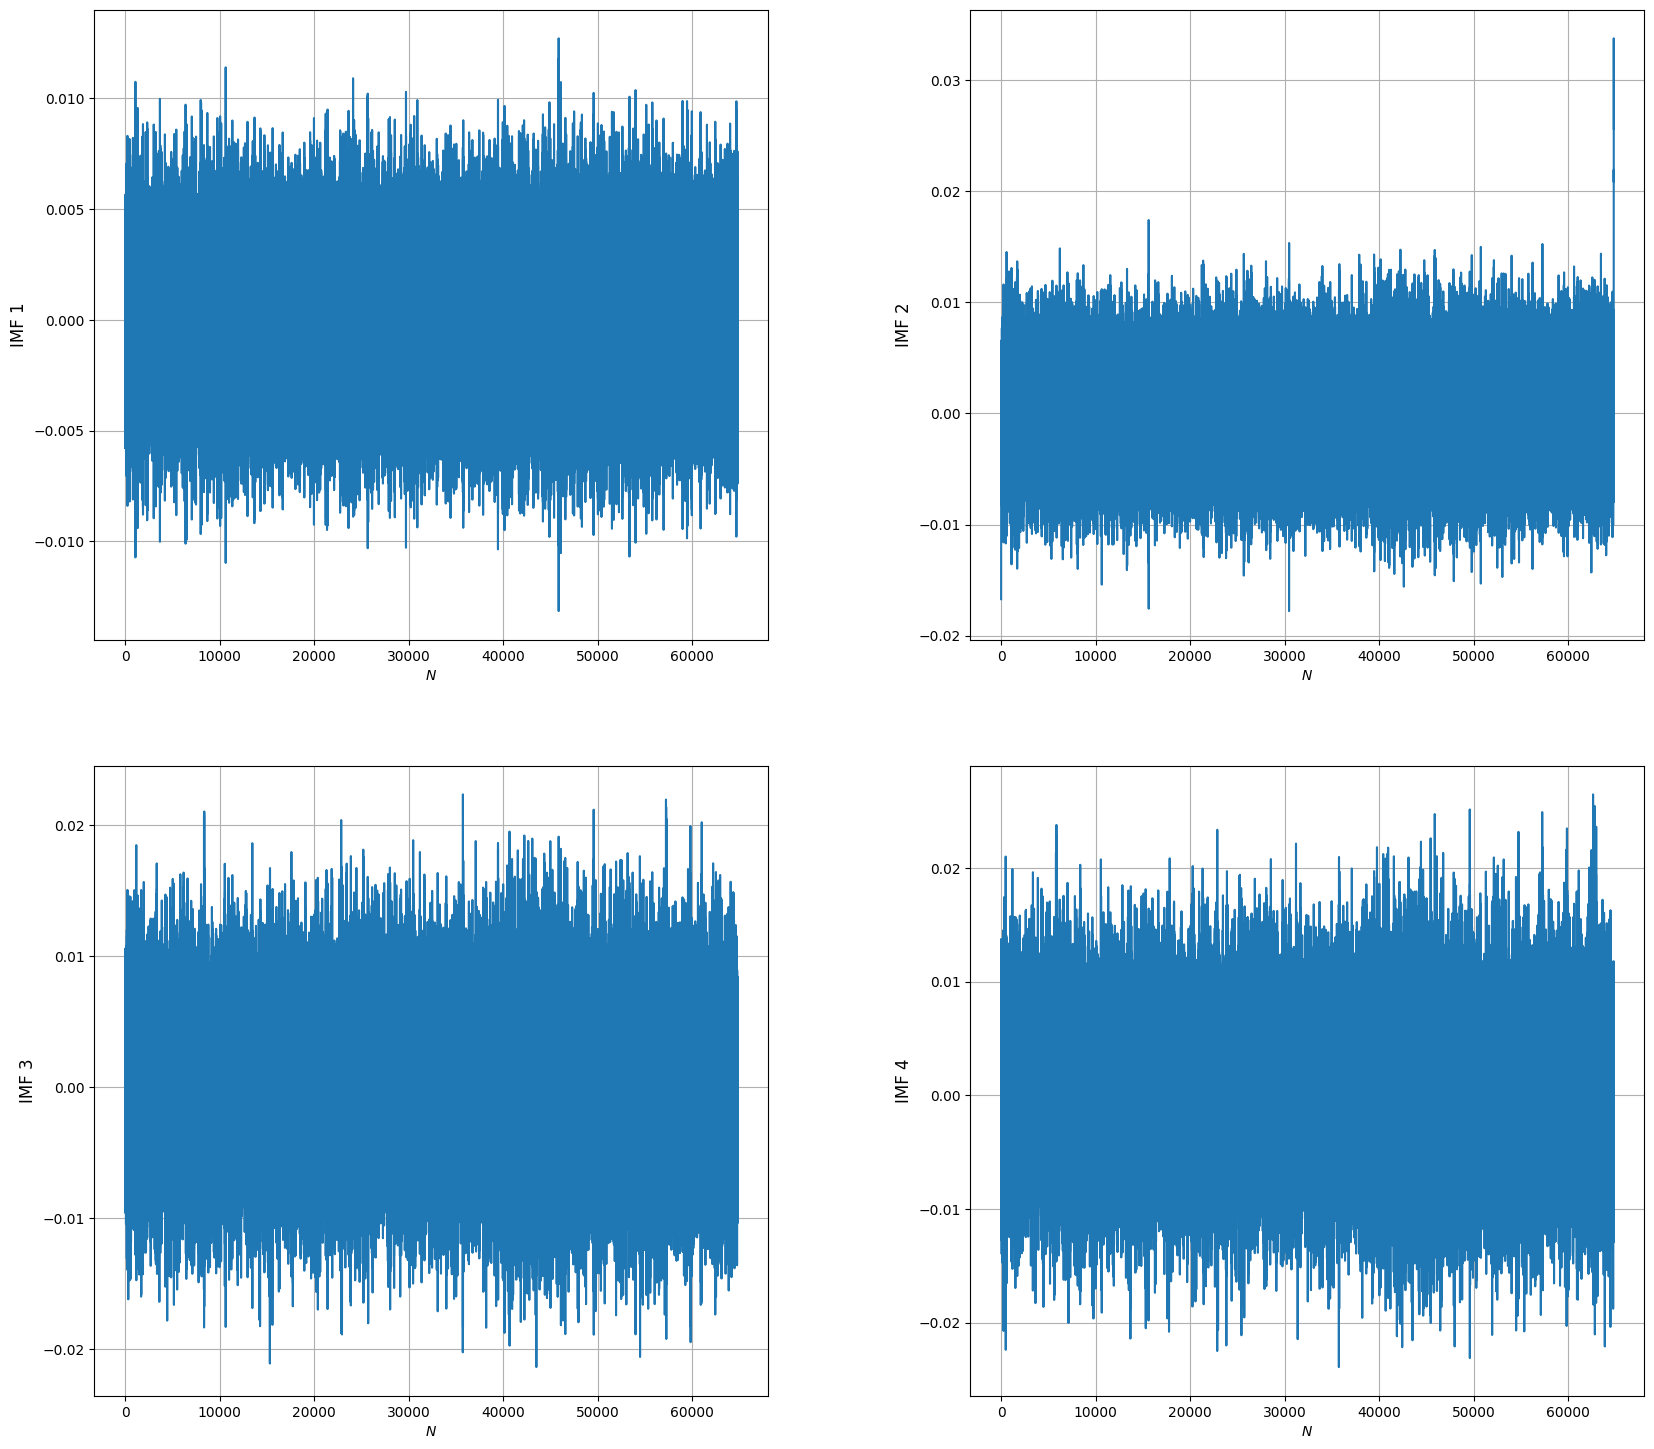

In [228]:
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axs.ravel()
for i in range(4):
    plt.rcParams['axes.formatter.use_locale'] = True
    axs[i].plot(train_transformed[:, i])
    axs[i].set_ylabel(f"IMF {i + 1}", fontsize=12)
    axs[i].set_xlabel("$\it{N}$")
    axs[i].grid(True)
    plt.show

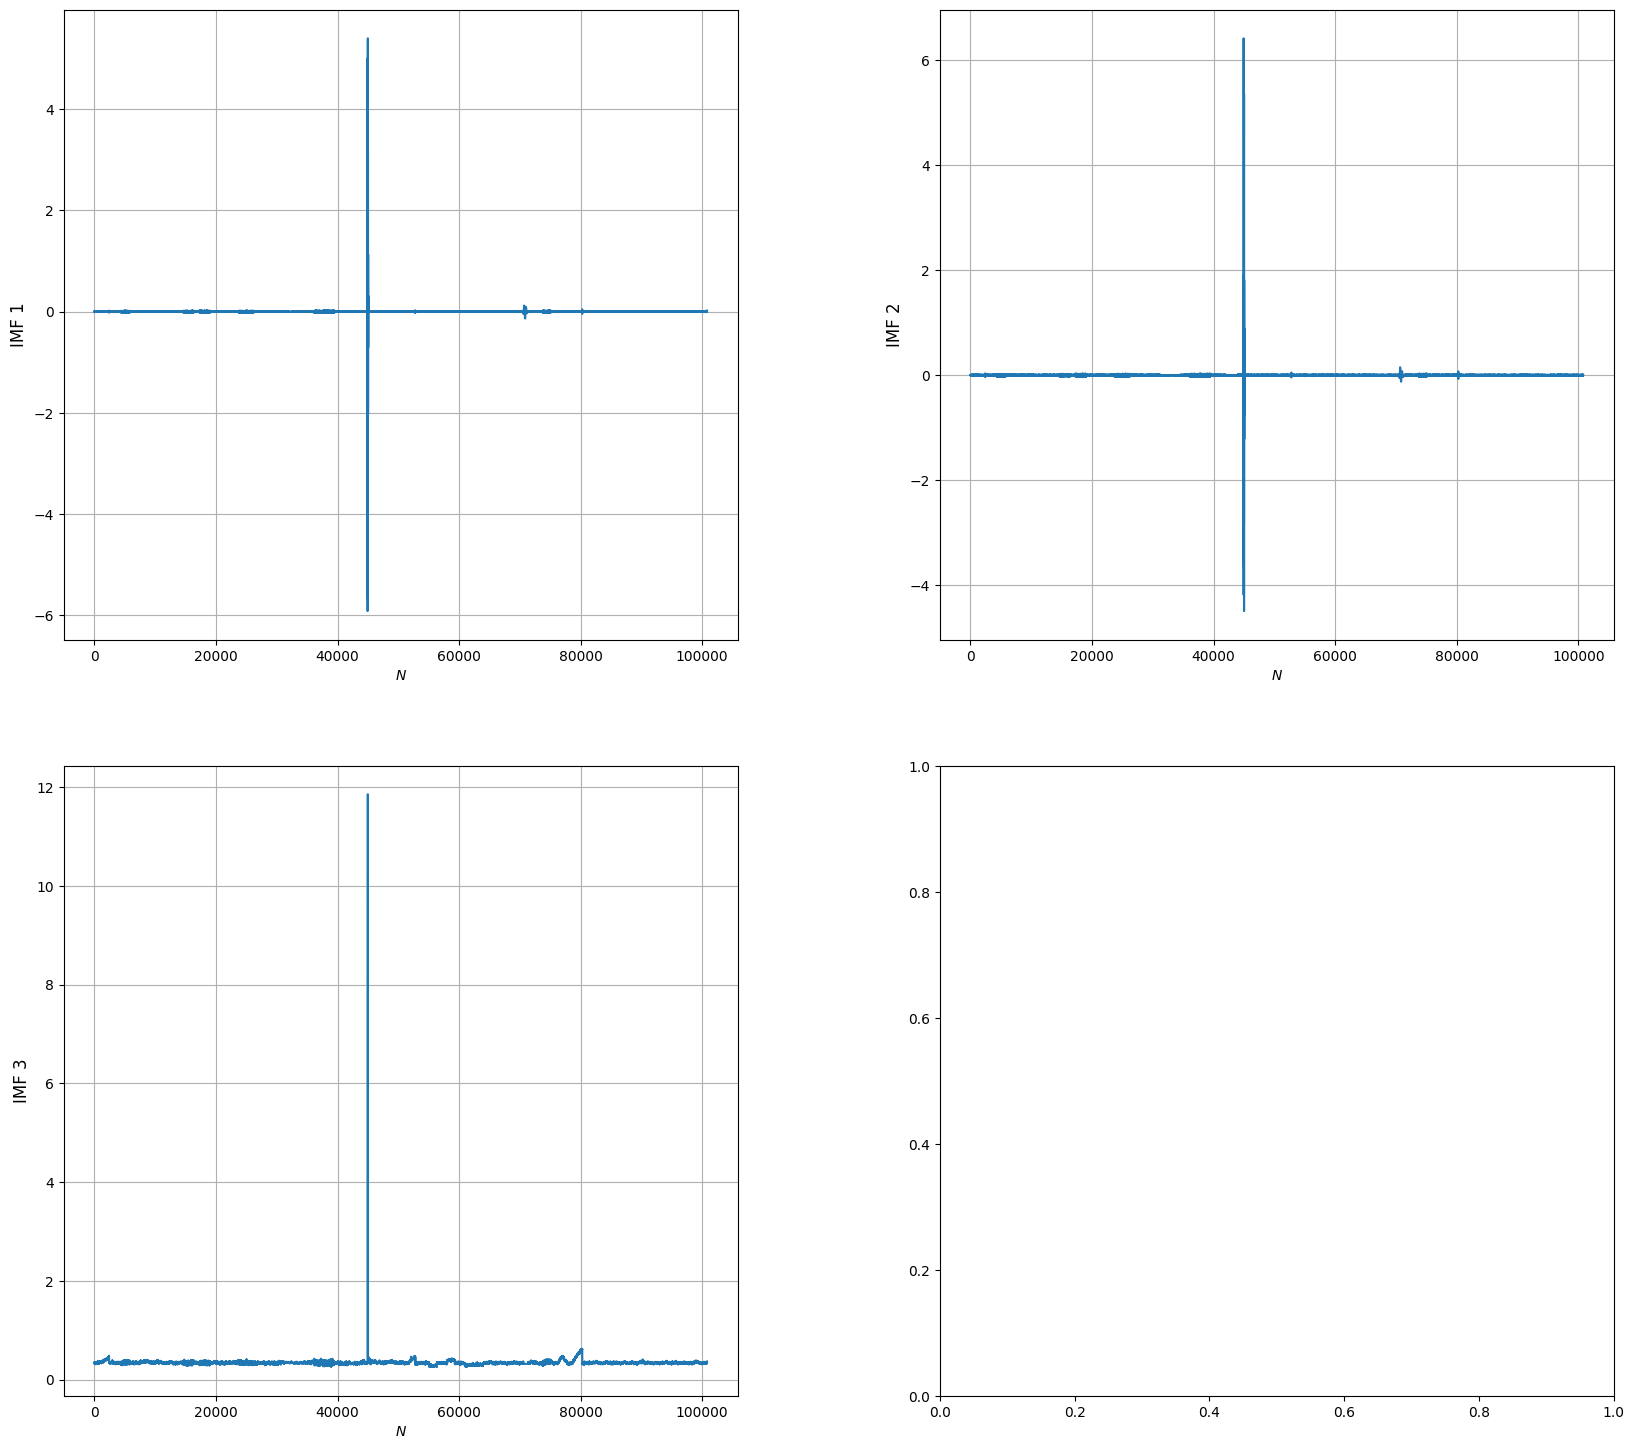

In [229]:
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axs.ravel()
for i in range(3):
    plt.rcParams['axes.formatter.use_locale'] = True
    axs[i].plot(test_transformed[:, i])
    axs[i].set_ylabel(f"IMF {i + 1}", fontsize=12)
    axs[i].set_xlabel("$\it{N}$")
    axs[i].grid(True)
    plt.show

## KNN модель для обнаружения аномалий

In [230]:
from pyod.models.knn import KNN
from sklearn.metrics import f1_score, accuracy_score

In [231]:
models = []

# Обрабатываем случай с различной размерностью IMFs
min_shape = min(train_transformed.shape[1], test_transformed.shape[1])

for i in range(min_shape):
    clf = KNN()
    clf.fit(train_transformed[:, i].reshape(-1, 1))
    models.append(clf)

Выполняем предсказание

In [232]:
predictions = np.vstack([model.predict(test_transformed[:, i].reshape(-1, 1)) for i, model in enumerate(models)]).T

In [233]:
predictions.shape

(100800, 3)

Используем Бэггинг для того, чтобы иметь несколько независимых моделей, которые мы будем комбинировать для дальнейшего окончательного результата (голосования)

In [234]:
from sklearn.ensemble import BaggingClassifier

In [235]:
bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))

BaggingClassifier(base_estimator=None, n_estimators=4, random_state=42)

In [236]:
ensemble_predictions = bagging_model.predict(predictions)

In [237]:
ensemble_predictions.shape

(100800,)

Произведем оценку модели






*   F1 score представляет собой совместную оценку точности и полноты. Данная метрика вычисляется по следующей формуле:

$F1 = \frac{2 \times precision \times recall}{precision + recall}$


*   Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству. Используем его как базовый



In [238]:
# Оценка модели
f1 = f1_score(np.ravel(X_masks), ensemble_predictions, average="macro")
accuracy = accuracy_score(np.ravel(X_masks), ensemble_predictions)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.6694645586429806
Accuracy: 0.7709722222222222


In [239]:
np.unique(ensemble_predictions, return_counts=True)

(array([0., 1.]), array([84339, 16461]))

In [240]:
np.unique(X_masks, return_counts=True)

(array([0., 1.]), array([72321, 28479]))

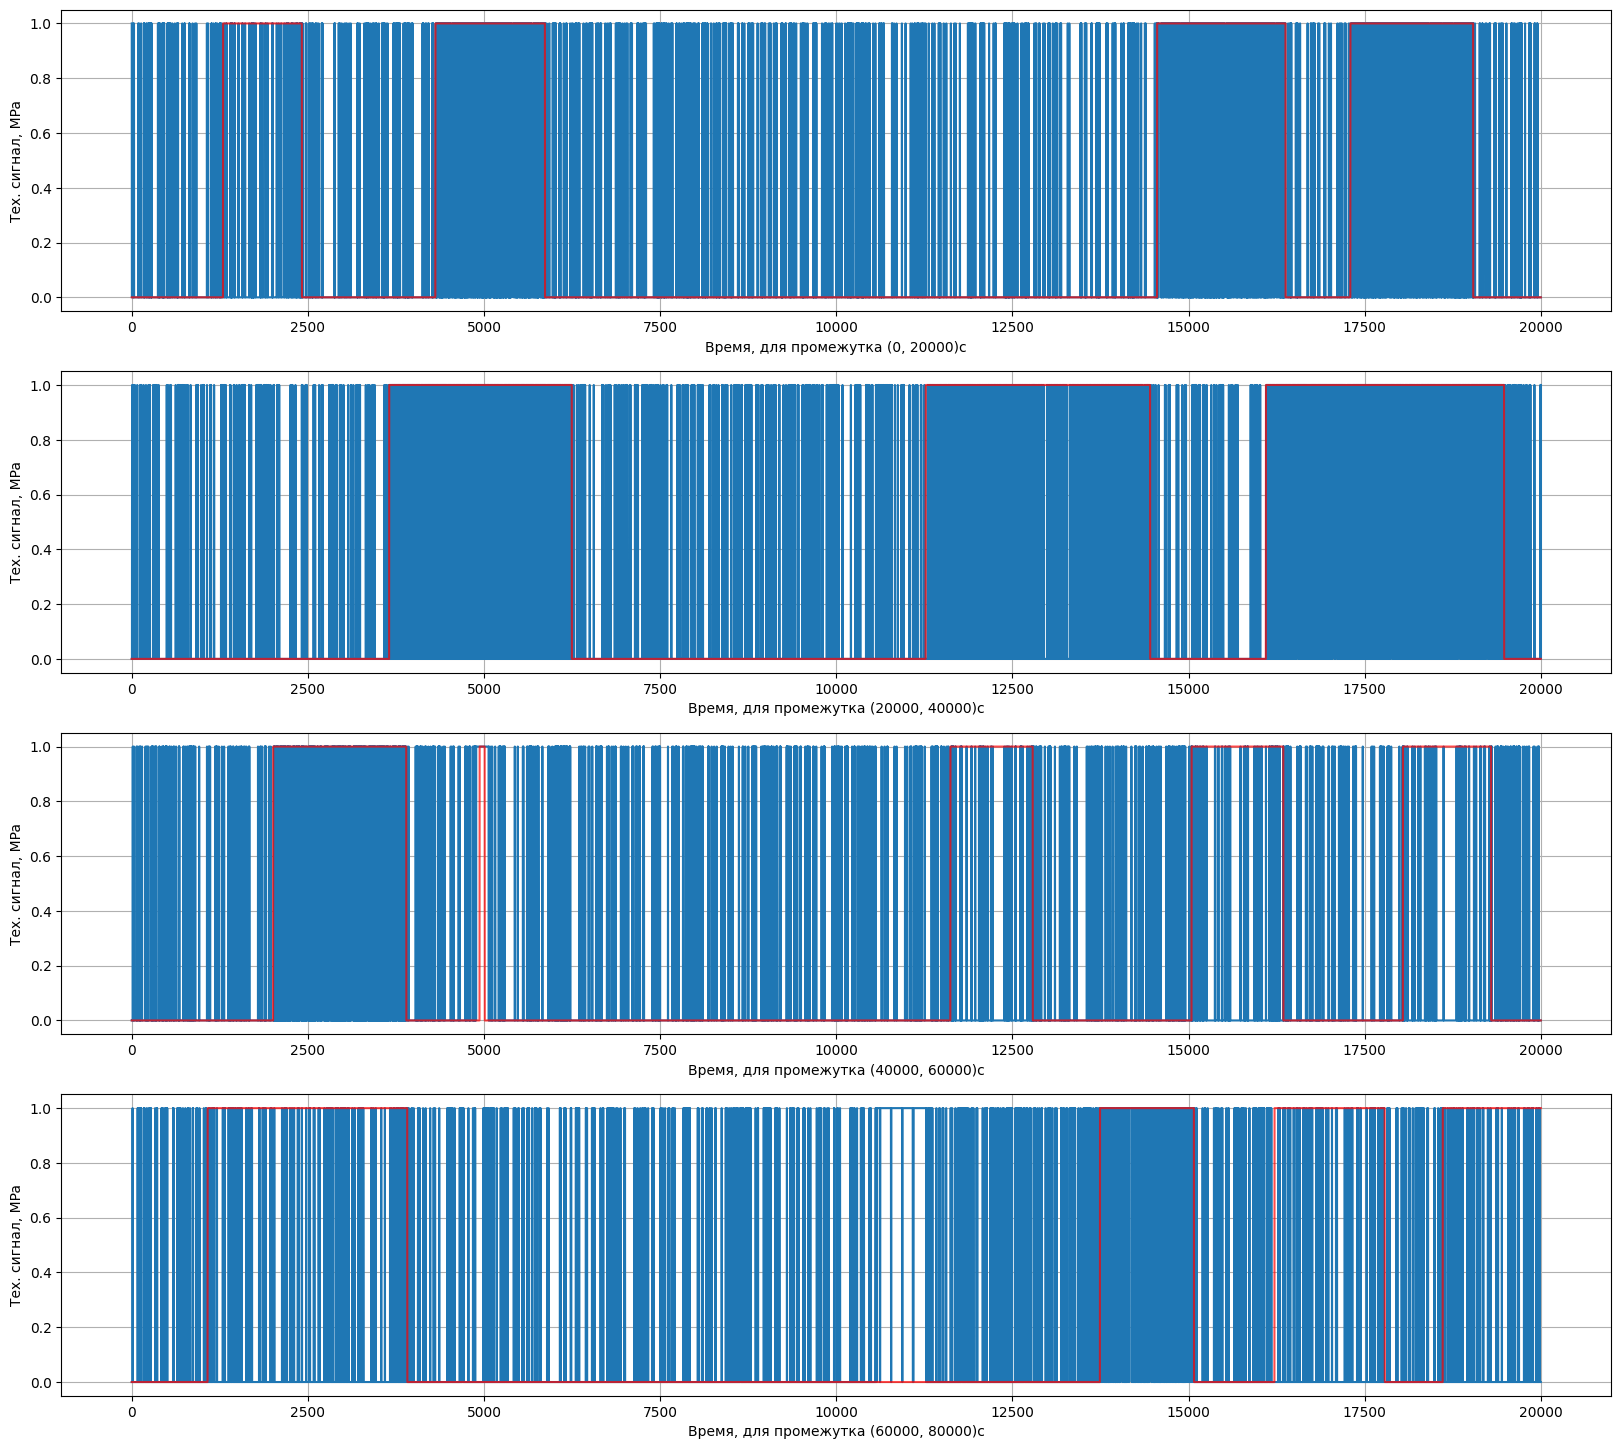

In [249]:
fig, axs = plt.subplots(4, 1, figsize=(20, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axs.ravel()
for i in range(4):
    axs[i].plot(ensemble_predictions[i * 20000:i * 20000 + 20000], color="tab:blue")
    axs[i].plot(X_masks.reshape(-1, 1)[i * 20000:i * 20000 + 20000], color="red", alpha=0.7)
    axs[i].set_xlabel(f"Время, для промежутка ({i * 20000}, {i * 20000 + 20000})с")
    axs[i].set_ylabel("Тех. сигнал, MPa")
    axs[i].grid(True)
    plt.show

В окресностях аномалий наблюдаются "уплотнения", что говорит о том, что модель их обнаруживает

## А теперь выполним эти действия для всех файлов

In [ ]:
metrics_results = []

for file_num in range(1, 10):
    print(f"signal = {file_num}")
    X_train = np.load(f"dataset/train/train{file_num}.npy")
    X_tests = np.load(f"dataset/test/test{file_num}.npy")
    X_masks = np.load(f"dataset/mask/mask{file_num}.npy")
    print("Данные прочитаны")
    res = {}

    X_tests = X_tests.reshape(-1, 1)
    X_masks = X_masks.reshape(-1, 1)

    num_levels = 4
    train_transformed = hht_transform(X_train, num_levels)
    test_transformed = hht_transform(X_tests, num_levels)
    print("Произведено преобразование Гильберта-Хуаннга")
    print(train_transformed.shape, test_transformed.shape)

    models = []
    min_shape = min(train_transformed.shape[1], test_transformed.shape[1])
    for i in range(min_shape):
        clf = KNN()
        clf.fit(train_transformed[:, i].reshape(-1, 1))
        models.append(clf)

    predictions = np.vstack([model.predict(test_transformed[:, i].reshape(-1, 1)) for i, model in enumerate(models)]).T

    # Применение бэггинга
    bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
    bagging_model.fit(predictions, np.ravel(X_masks))

    ensemble_predictions = bagging_model.predict(predictions)

    # Оценка модели
    f1 = f1_score(np.ravel(X_masks), ensemble_predictions, average="macro")
    accuracy = accuracy_score(np.ravel(X_masks), ensemble_predictions)
    print(f"{file_num})\tF1 Score: {f1}\tAccuracy: {accuracy}")
    res["metrics"] = (f1, accuracy)
    metrics_results.append(res)

signal = 1
Данные прочитаны
Mode 2, Iteration 600
1 minima > 0; 11840 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 11890 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 11943 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 7298 maxima < 0.
Mode 4, Iteration 1400
0 minima > 0; 4304 maxima < 0.
Mode 9, Iteration 1600
2 minima > 0; 172 maxima < 0.
Mode 13, Iteration 1800
0 minima > 0; 10 maxima < 0.
Mode 1, Iteration 600
0 minima > 0; 32965 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 33036 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 33114 maxima < 0.
Mode 2, Iteration 1200
19 minima > 0; 19935 maxima < 0.
Mode 2, Iteration 1400
7 minima > 0; 20257 maxima < 0.
Mode 2, Iteration 1600
1 minima > 0; 20374 maxima < 0.
Mode 2, Iteration 1800
3 minima > 0; 20478 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Произведено преобразование Гильберта-Хуаннга
(64800, 4) (100800, 3)
1)	F1 Score: 0.6694645586429806	Accuracy: 0.7709722222222222
signal = 2
Данные прочитаны
Mode 1, Iteration 600
2 minima > 0; 20438 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 20513 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 20572 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 20601 maxima < 0.
Mode 1, Iteration 1400
0 minima > 0; 20626 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 20655 maxima < 0.
Mode 1, Iteration 1800
0 minima > 0; 20686 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
6 minima > 0; 23339 maxima < 0.
Mode 1, Iteration 800
6 minima > 0; 23422 maxima < 0.
Mode 1, Iteration 1000
7 minima > 0; 23474 maxima < 0.
Mode 1, Iteration 1200
5 minima > 0; 23524 maxima < 0.
Mode 1, Iteration 1400
4 minima > 0; 23567 maxima < 0.
Mode 1, Iteration 1600
1 minima > 0; 23599 maxima < 0.
Mode 1, Iteration 1800
1 minima > 0; 23628 maxima < 0.
Произведено преобразование Гильберта-Хуаннга
(86400, 2) (100800, 2)
2)	F1 Score: 0.8528013339372861	Accuracy: 0.8651587301587301
signal = 3
Данные прочитаны
Mode 1, Iteration 600
1 minima > 0; 21985 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 22083 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 22176 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 22240 maxima < 0.
Mode 1, Iteration 1400
1 minima > 0; 22295 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 22336 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 22363 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 25303 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 25397 maxima < 0.
Mode 1, Iteration 1000
2 minima > 0; 25470 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 25529 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 25584 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 25619 maxima < 0.
Mode 1, Iteration 1800
2 minima > 0; 25638 maxima < 0.
Произведено преобразование Гильберта-Хуаннга
(86400, 3) (100800, 2)
3)	F1 Score: 0.678578475266245	Accuracy: 0.7738888888888888
signal = 4
Данные прочитаны
Mode 1, Iteration 600
0 minima > 0; 19084 maxima < 0.
Mode 2, Iteration 800
2 minima > 0; 8897 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 8927 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 5753 maxima < 0.
Mode 5, Iteration 1400
1 minima > 0; 2027 maxima < 0.
Mode 14, Iteration 1600
0 minima > 0; 4 maxima < 0.
Mode 1, Iteration 600
0 minima > 0; 25298 maxima < 0.
Mode 2, Iteration 800
3 minima > 0; 12330 maxima < 0.
Mode 2, Iteration 1000
3 minima 

/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Произведено преобразование Гильберта-Хуаннга
(86400, 4) (100800, 4)
4)	F1 Score: 0.7313939175130991	Accuracy: 0.7553769841269842
signal = 5
Данные прочитаны
Mode 1, Iteration 600
1 minima > 0; 23871 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 23981 maxima < 0.
Mode 2, Iteration 1000
7 minima > 0; 13725 maxima < 0.
Mode 2, Iteration 1200
3 minima > 0; 13894 maxima < 0.
Mode 2, Iteration 1400
3 minima > 0; 13989 maxima < 0.
Mode 2, Iteration 1600
2 minima > 0; 14059 maxima < 0.
Mode 2, Iteration 1800
1 minima > 0; 14116 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 24129 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 24247 maxima < 0.
Mode 1, Iteration 1000
0 minima > 0; 24338 maxima < 0.
Mode 1, Iteration 1200
2 minima > 0; 24411 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 24462 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 24517 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 24560 maxima < 0.
Произведено преобразование Гильберта-Хуаннга
(86400, 3) (100800, 2)
5)	F1 Score: 0.5628058192784217	Accuracy: 0.7045833333333333
signal = 6
Данные прочитаны
Mode 5, Iteration 600
2689 minima > 0; 0 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 3253 maxima < 0.
Mode 6, Iteration 1000
2 minima > 0; 1904 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 66 maxima < 0.
Mode 1, Iteration 600
5 minima > 0; 33373 maxima < 0.
Mode 1, Iteration 800
5 minima > 0; 33497 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 33576 maxima < 0.
Mode 1, Iteration 1200
5 minima > 0; 33644 maxima < 0.
Mode 1, Iteration 1400
2 mini

/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Произведено преобразование Гильберта-Хуаннга
(86400, 4) (100800, 2)
6)	F1 Score: 0.6148679500535333	Accuracy: 0.7460714285714286
signal = 7
Данные прочитаны
Mode 1, Iteration 600
8 minima > 0; 26361 maxima < 0.
Mode 1, Iteration 800
4 minima > 0; 26448 maxima < 0.
Mode 1, Iteration 1000
5 minima > 0; 26523 maxima < 0.
Mode 1, Iteration 1200
3 minima > 0; 26593 maxima < 0.
Mode 1, Iteration 1400
3 minima > 0; 26634 maxima < 0.
Mode 1, Iteration 1600
2 minima > 0; 26682 maxima < 0.
Mode 1, Iteration 1800
1 minima > 0; 26712 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
25 minima > 0; 20263 maxima < 0.
Mode 1, Iteration 800
13 minima > 0; 20429 maxima < 0.
Mode 1, Iteration 1000
7 minima > 0; 20533 maxima < 0.
Mode 1, Iteration 1200
8 minima > 0; 20604 maxima < 0.
Mode 1, Iteration 1400
5 minima > 0; 20668 maxima < 0.
Mode 1, Iteration 1600
10 minima > 0; 20711 maxima < 0.
Mode 1, Iteration 1800
11 minima > 0; 20768 maxima < 0.
Произведено преобразование Гильберта-Хуаннга
(86400, 2) (100800, 2)
7)	F1 Score: 0.4495396435081113	Accuracy: 0.6455357142857143
signal = 8
Данные прочитаны
Mode 1, Iteration 600
2 minima > 0; 27702 maxima < 0.
Mode 1, Iteration 800
0 minima > 0; 27824 maxima < 0.
Mode 1, Iteration 1000
0 minima > 0; 27939 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 28035 maxima < 0.
Mode 2, Iteration 1400
2 minima > 0; 16104 maxima < 0.
Mode 3, Iteration 1600
11 minima > 0; 9425 maxima < 0.
Mode 4, Iteration 1800
3 minima > 0; 5778 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 31363 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 31566 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 31665 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 31756 maxima < 0.
Mode 1, Iteration 1400
1 minima > 0; 31847 maxima < 0.
Mode 1, Iteration 1600
2 minima > 0; 31906 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 31957 maxima < 0.
Произведено преобразование Гильберта-Хуаннга
(86400, 4) (100800, 2)
8)	F1 Score: 0.7043633891861729	Accuracy: 0.7504761904761905
signal = 9
Данные прочитаны
Mode 2, Iteration 600
0 minima > 0; 13163 maxima < 0.
Mode 2, Iteration 800
0 minima > 0; 13282 maxima < 0.
Mode 3, Iteration 1000
159 minima > 0; 7902 maxima < 0.
Mode 4, Iteration 1200
2 minima > 0; 5166 maxima < 0.
Mode 9, Iteration 1400
1 minima > 0; 195 maxima < 0.
Mode 1, Iteration 600
3 minima > 0; 27090 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 27283 maxima < 0.
Mode 1, Iteration 1000
4 minima > 0; 27433 maxima < 0.
Mode 1, Iteration 1200
0 m

/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Произведено преобразование Гильберта-Хуаннга
(86400, 4) (100800, 2)
9)	F1 Score: 0.4060692278363107	Accuracy: 0.6831845238095238


Обобщим результаты

In [ ]:
# Итоговые результаты
results = {"metrics": [0, 0]}
for res in metrics_results:
    results["metrics"][0] += res["metrics"][0]
    results["metrics"][1] += res["metrics"][1]

for key in results:
    results["metrics"][0] = results[key][0] / len(metrics_results)
    results["metrics"][1] = results[key][1] / len(metrics_results)

print(f'F1: {results["metrics"][0]}, Accuracy: {results["metrics"][1]}')

F1: 0.6299871461357957, Accuracy: 0.7439164462081128


F1: 0.6299871461357957 и Accuracy: 0.7439164462081128, предоставляют общую оценку производительности модели на тестовых данных.

В итоге мы имеем высокий показатель (Accuracy), что хорошо, но также модель имеет некоторое пространство для улучшения в метрике F1.

Имеется дисбаланс классов, т.к. аномалия возникает периодически. Исходя из этого нам следует обращать внимание на метрику F1.

В наборе данных встречаются такие аномалии, значение которых сильно отличаются по своему абсолютному значению не только от чистого сигнала, но и от других менее "резких" аномалий. Это вносит определенную долю выбросов в набор данных и поэтому метрики не достигают очень высоких показателей.

## Ниже я хочу рассмотреть отдельно второй сигнал, т.к. в цикле он показал наилучшие значение на всем наборе

In [195]:
for file_num in range(2, 3):
    print(f"signal = {file_num}")
    X_train = np.load(f"dataset/train/train{file_num}.npy")
    X_tests = np.load(f"dataset/test/test{file_num}.npy")
    X_masks = np.load(f"dataset/mask/mask{file_num}.npy")

signal = 2


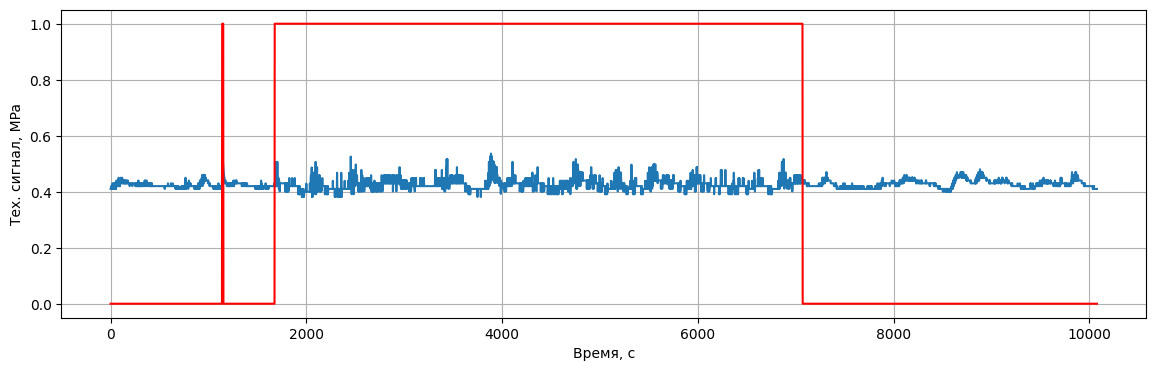

In [196]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests[0])
ax1.plot(X_masks[0], color="red")
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

Рассмотрел для длинного непрерывного участка без выбросов, чтобы убедиться в способности точного предсказания аномалий модели

In [198]:
X_tests = np.concatenate([X_tests[6:]]).reshape(-1, 1)
X_masks = np.concatenate([X_masks[6:]]).reshape(-1, 1)

In [199]:
print("Размеры данных для обучения:", X_train.shape)
print("Размеры тестовых данных:", X_tests.shape)
print("Размеры маски аномалий:", X_masks.shape)

Размеры данных для обучения: (86400,)
Размеры тестовых данных: (40320, 1)
Размеры маски аномалий: (40320, 1)


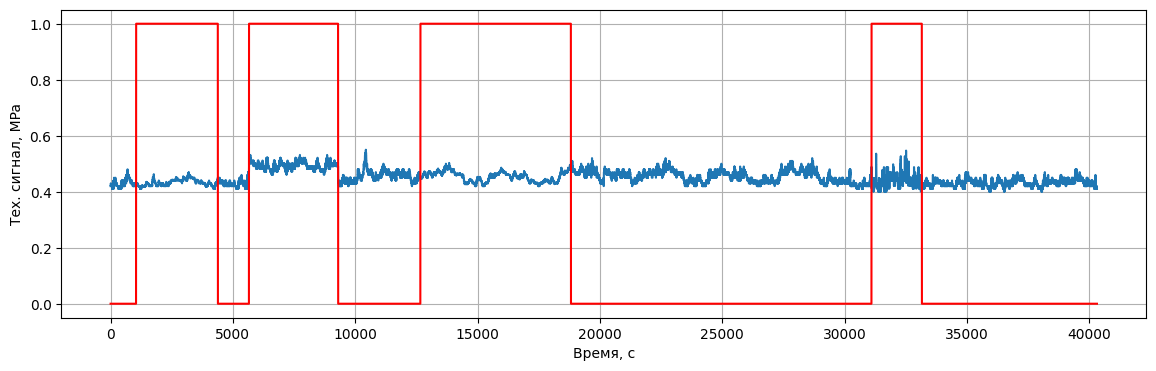

In [200]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests)
ax1.plot(X_masks, color="red")
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [201]:
num_levels = 4
train_transformed = hht_transform(X_train, num_levels)
test_transformed = hht_transform(X_tests, num_levels)

Mode 1, Iteration 600
2 minima > 0; 20438 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 20513 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 20572 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 20601 maxima < 0.
Mode 1, Iteration 1400
0 minima > 0; 20626 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 20655 maxima < 0.
Mode 1, Iteration 1800
0 minima > 0; 20686 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
2 minima > 0; 9125 maxima < 0.
Mode 1, Iteration 800
0 minima > 0; 9167 maxima < 0.
Mode 1, Iteration 1000
3 minima > 0; 9186 maxima < 0.
Mode 1, Iteration 1200
2 minima > 0; 9209 maxima < 0.
Mode 1, Iteration 1400
0 minima > 0; 9223 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 9237 maxima < 0.
Mode 1, Iteration 1800
0 minima > 0; 9252 maxima < 0.


In [202]:
print(train_transformed.shape, test_transformed.shape)

(86400, 2) (40320, 2)


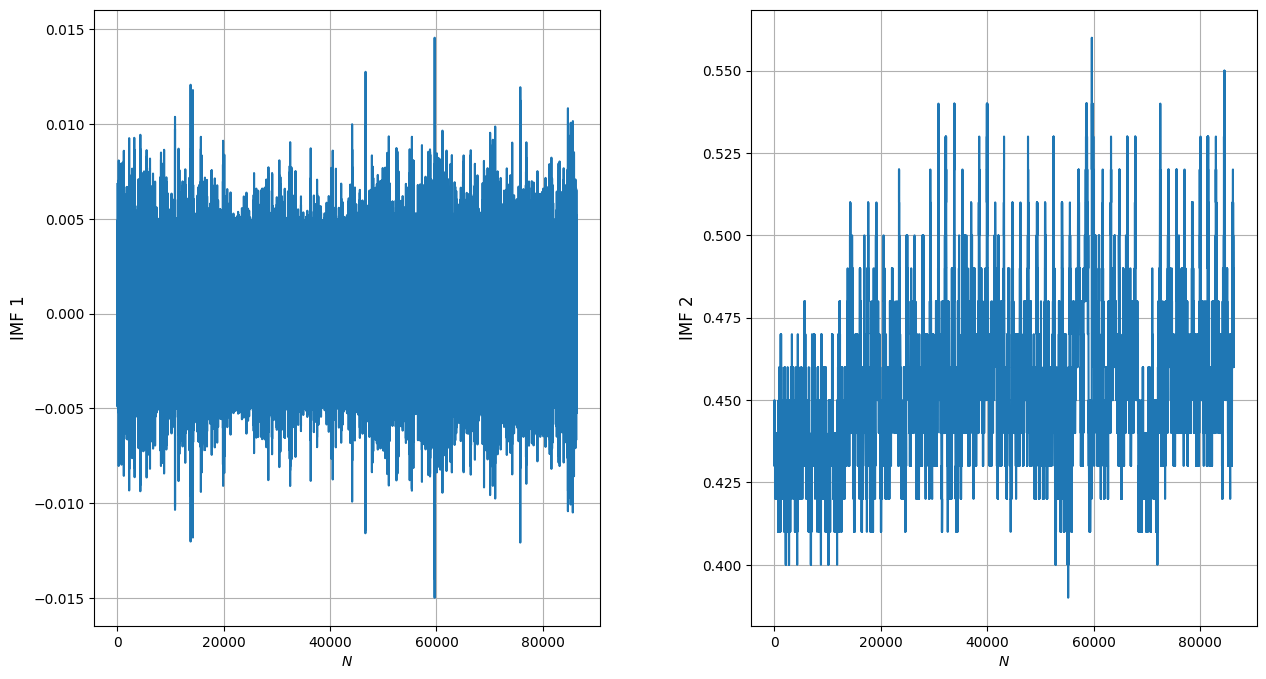

In [203]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axs.ravel()
for i in range(2):
    plt.rcParams['axes.formatter.use_locale'] = True
    axs[i].plot(train_transformed[:, i])
    axs[i].set_ylabel(f"IMF {i + 1}", fontsize=12)
    axs[i].set_xlabel("$\it{N}$")
    axs[i].grid(True)
    plt.show

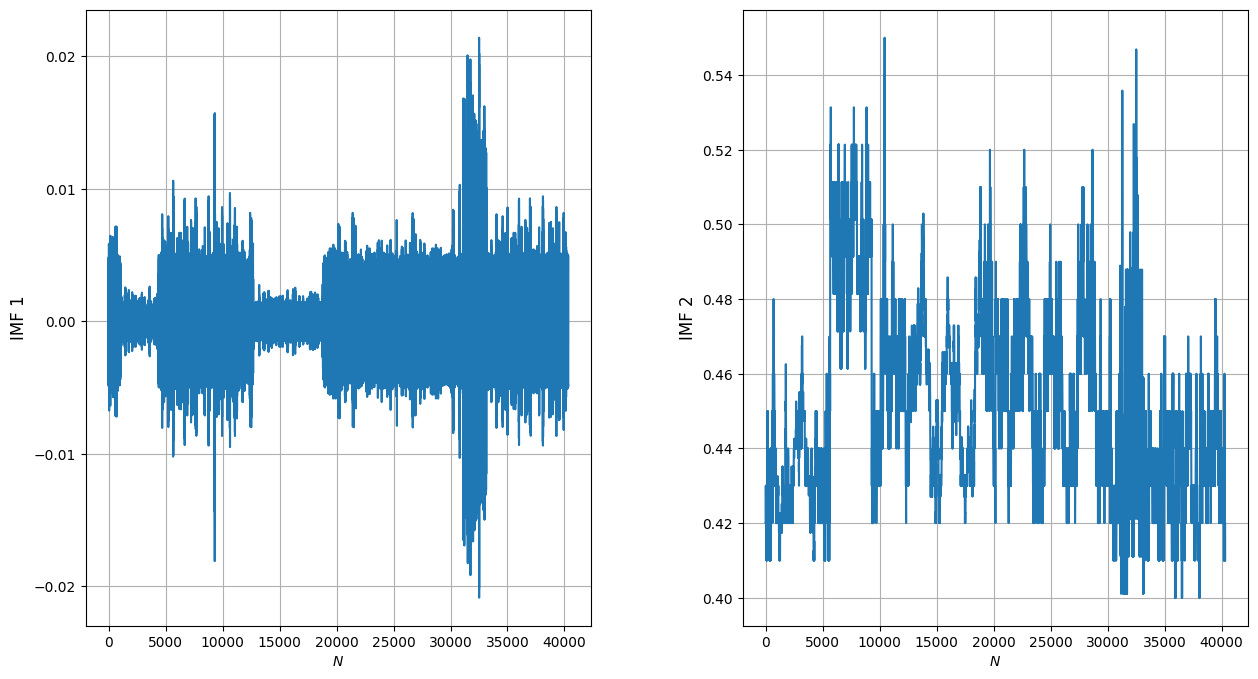

In [204]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axs.ravel()
for i in range(2):
    plt.rcParams['axes.formatter.use_locale'] = True
    axs[i].plot(test_transformed[:, i])
    axs[i].set_ylabel(f"IMF {i + 1}", fontsize=12)
    axs[i].set_xlabel("$\it{N}$")
    axs[i].grid(True)
    plt.show

In [208]:
models = []
min_shape = min(train_transformed.shape[1], test_transformed.shape[1])
for i in range(min_shape):
    clf = KNN()
    clf.fit(train_transformed[:, i].reshape(-1, 1))
    models.append(clf)

In [209]:
predictions = np.vstack([model.predict(test_transformed[:, i].reshape(-1, 1)) for i, model in enumerate(models)]).T

In [210]:
bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))

BaggingClassifier(base_estimator=None, n_estimators=4, random_state=42)

In [211]:
ensemble_predictions = bagging_model.predict(predictions)

In [212]:
f1 = f1_score(np.ravel(X_masks), ensemble_predictions, average="macro")
accuracy = accuracy_score(np.ravel(X_masks), ensemble_predictions)
print(f"F1 Score: {f1}\tAccuracy: {accuracy}")

F1 Score: 0.7704334321805137	Accuracy: 0.8134176587301587


In [213]:
np.unique(ensemble_predictions, return_counts=True)

(array([0., 1.]), array([32644,  7676]))

In [214]:
np.unique(X_masks, return_counts=True)

(array([0., 1.]), array([25123, 15197]))

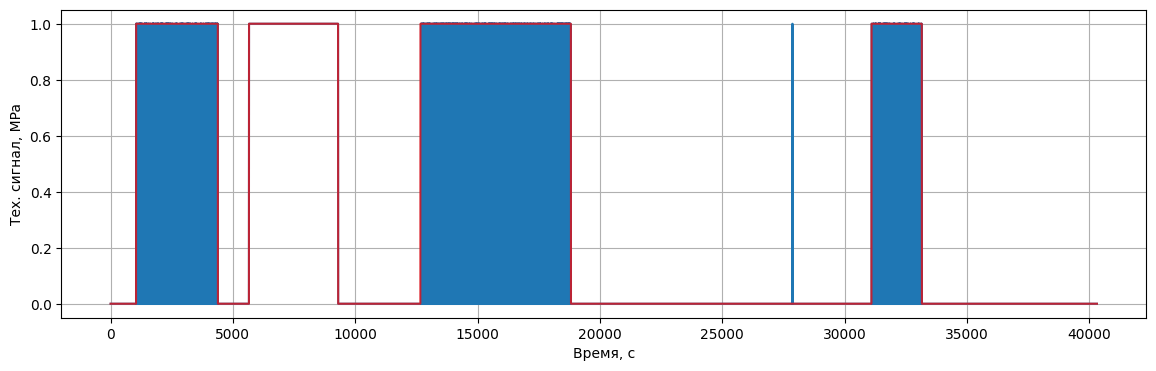

In [216]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(ensemble_predictions[:], color="tab:blue")
ax1.plot(X_masks.reshape(-1, 1)[:], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

Судя по графику выше модель справляется с поиском аномалий в сигнале